In [3]:
# conda env create --force -f environment.yml

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import scipy

from typing import List

from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

# Load data

In [5]:
median_ensemble_test = pd.read_csv("./delivery_1_cv_v7_seeds/split_v7_2021_test_cc_dispatcher_precision_recall_harmonic_mean_median_ensemble_individual_predictions.csv")
median_ensemble_val = pd.read_csv("./delivery_1_cv_v7_seeds/split_v7_2021_test_cc_dispatcher_precision_recall_harmonic_mean_median_ensemble_individual_predictions_val.csv")

In [6]:
all_ensembles_test = pd.read_csv("./delivery_1_cv_v7_seeds/split_v7_2021_test_cc_dispatcher_precision_recall_harmonic_mean_predictions.csv")
all_ensembles_val = pd.read_csv("./delivery_1_cv_v7_seeds/split_v7_2021_test_cc_dispatcher_precision_recall_harmonic_mean_predictions_val.csv")

In [7]:
median_ensemble_test.rename(
    columns={
        "logits 20": "logits 1",
        "logits 21": "logits 2",
        "logits 22": "logits 3",
        "logits 23": "logits 4",
        "logits 24": "logits 5",
        "probs 20": "probs 1",
        "probs 21": "probs 2",
        "probs 22": "probs 3",
        "probs 23": "probs 4",
        "probs 24": "probs 5",
    },
    inplace=True,
)
median_ensemble_test["ensemble_preds"] = median_ensemble_test["ensemble_probs"] > 0.5
median_ensemble_test

,db_id,logits 1,probs 1,logits 2,probs 2,logits 3,probs 3,logits 4,probs 4,logits 5,...,ensemble_logits,ensemble_probs,y,h,gender,age,apotype,criteria_code,response_plan_type,ensemble_preds
0,63d13ca5c800e251f5a62955,-72.178530,4.500530e-32,-66.218025,1.745328e-29,-55.653380,6.761508e-25,-76.120890,8.732096e-34,-88.917690,...,-74.293595,1.630363e-26,False,False,M,45,NaN,SS.80.02,NaN,False
1,63d13ca5c800e251f5a6295d,-10.247177,3.545620e-05,-8.622528,1.799722e-04,-5.482232,4.142800e-03,-8.343964,2.377713e-04,-8.653581,...,-10.745789,1.096768e-04,False,False,M,71,NaN,SS.05.03,NaN,False
2,63d13ca5c800e251f5a62973,-40.920770,1.691749e-18,-34.051163,1.628425e-15,-30.341011,6.653747e-14,-32.563976,7.205179e-15,-40.366640,...,-38.124604,1.720343e-15,False,False,M,62,NaN,SS.23.02,NaN,False
3,63d13ca5c800e251f5a62978,-7.191583,7.523298e-04,-4.759127,8.500219e-03,-4.939091,7.110190e-03,-4.932843,7.154435e-03,-6.189132,...,-8.078248,4.309183e-04,False,False,K,19,NaN,SS.80.02,NaN,False
4,63d13ca5c800e251f5a6297f,-34.431263,1.113506e-15,-19.847315,2.401158e-09,-25.825691,6.081977e-12,-22.582930,1.557250e-10,-28.777185,...,-28.768769,3.347356e-11,False,False,K,54,NaN,SS.80.02,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344025,63d17383c800e251f5c2febb,-44.388920,5.273963e-20,-40.020195,4.163419e-18,-51.207260,5.767259e-23,-71.035600,1.411339e-31,-55.670720,...,-54.940430,5.512445e-20,False,False,K,38,NaN,SS.22.04.04.01.03,NaN,False
344026,63d17383c800e251f5c2febc,-15.530102,1.800373e-07,-22.301985,2.062391e-10,-20.193808,1.698012e-09,-21.667791,3.888640e-10,-30.577436,...,-24.530117,3.107720e-09,False,False,M,60,NaN,SS.05.01.08,NaN,False
344027,63d17383c800e251f5c2fedc,-104.084210,0.000000e+00,-63.133587,3.814447e-28,-53.949482,3.715674e-24,-77.870570,1.517897e-34,-132.943700,...,-88.872203,8.959761e-26,False,False,M,51,NaN,SS.01.04.03.02,NaN,False
344028,63d17383c800e251f5c2fee9,-9.669975,6.314743e-05,-9.837898,5.338655e-05,-5.304157,4.946298e-03,-10.413909,3.001123e-05,-11.013101,...,-11.723701,1.222656e-04,False,False,K,68,NaN,SS.27.05,NaN,False


In [8]:
def plot_histogram(arrays: List[np.ndarray], labels: List, **kwargs):
    fig, ax = plt.subplots(figsize=(6.4, 4.8))

    for array, label in zip(arrays, labels):
        ax.hist(array, bins=kwargs.get("bins", 50), alpha=kwargs.get("alpha", 0.5), label=label)

    ax.set_yscale(kwargs.get("yscale", "log"))
    ax.legend()
    return fig, ax

In [9]:
def plot_calibration_curve(targets: List[np.ndarray], model_probs: List[np.ndarray], labels=None, **kwargs):
    if not isinstance(targets, list):
        targets = [targets]
    if not isinstance(model_probs, list):
        model_probs = [model_probs]

    if len(model_probs) != len(targets):
        assert len(model_probs) == 1 or len(targets) == 1, "Number of models and targets must be equal or 1"
        if len(model_probs) == 1:
            model_probs = model_probs * len(targets)
        else:
            targets = targets * len(model_probs)

    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for target, probs, label in zip(targets, model_probs, labels):
        prob_true, prob_pred = calibration_curve(
            target,
            probs,
            n_bins=kwargs.get("n_bins", 20),
            strategy=kwargs.get("strategy", "uniform")
        )
        ax.plot(prob_pred, prob_true, marker="o", markersize=3, label=label)

    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.legend()
    return fig, ax

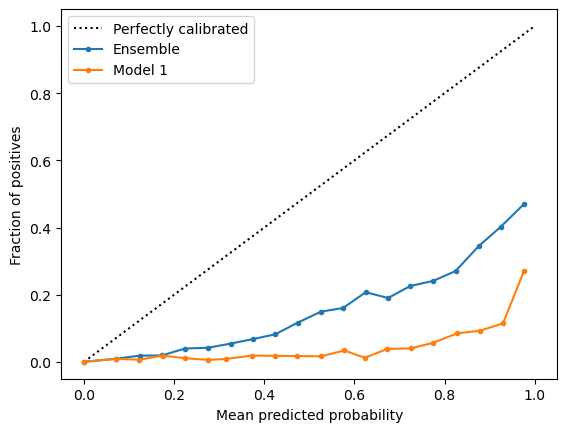

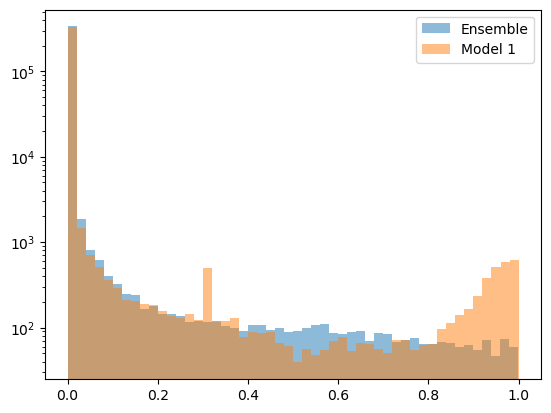

In [10]:
plot_calibration_curve(
    targets=median_ensemble_test["y"],
    model_probs=[median_ensemble_test["ensemble_probs"], median_ensemble_test["probs 1"]],
    labels=["Ensemble", "Model 1"],
    n_bins=20,
)
fig, ax = plot_histogram(arrays=[median_ensemble_test["ensemble_probs"], median_ensemble_test["probs 1"]], labels=["Ensemble", "Model 1"])
fig.savefig("histogram_ensemble_and_model_1.pdf", bbox_inches="tight")

(<Figure size 640x480 with 1 Axes>, <Axes: >)

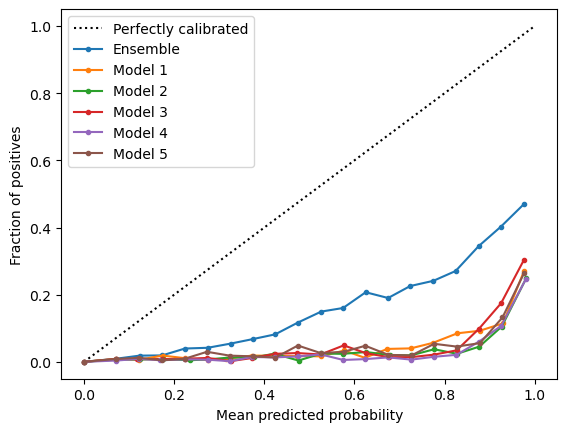

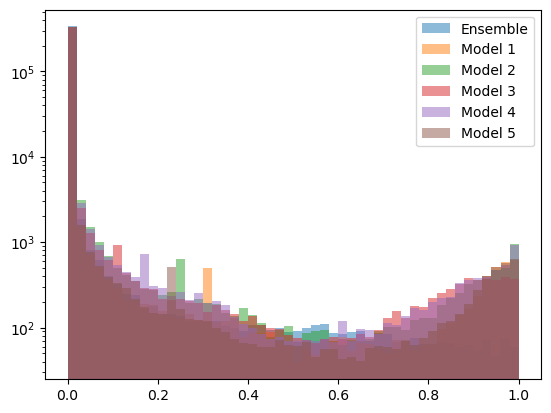

In [11]:
fig, ax = plot_calibration_curve(
    targets=median_ensemble_test["y"],
    model_probs=[
        median_ensemble_test["ensemble_probs"],
        median_ensemble_test["probs 1"],
        median_ensemble_test["probs 2"],
        median_ensemble_test["probs 3"],
        median_ensemble_test["probs 4"],
        median_ensemble_test["probs 5"],
    ],
    labels=["Ensemble", "Model 1", "Model 2", "Model 3", "Model 4", "Model 5"],
    n_bins=20,
)
fig.savefig("calibration_curve_ensemble_and_models.pdf", bbox_inches="tight")
plot_histogram(
    arrays=[
        median_ensemble_test["ensemble_probs"],
        median_ensemble_test["probs 1"],
        median_ensemble_test["probs 2"],
        median_ensemble_test["probs 3"],
        median_ensemble_test["probs 4"],
        median_ensemble_test["probs 5"],
    ],
    labels=["Ensemble", "Model 1", "Model 2", "Model 3", "Model 4", "Model 5"],
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

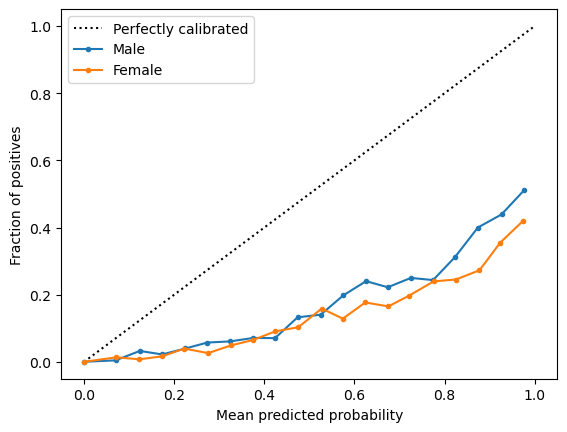

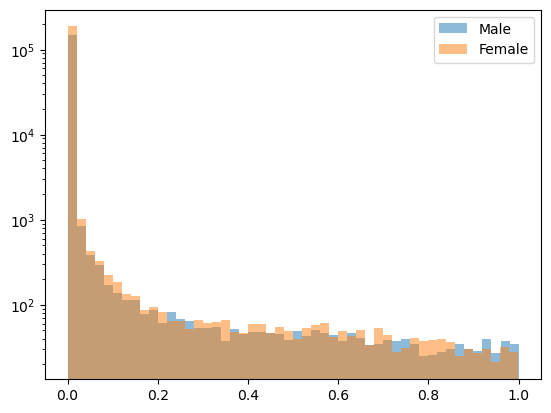

In [12]:
is_male = median_ensemble_test["gender"] == "M"
is_female = median_ensemble_test["gender"] == "K"
plot_calibration_curve(
    targets=[median_ensemble_test["y"][is_male], median_ensemble_test["y"][is_female]],
    model_probs=[median_ensemble_test["ensemble_probs"][is_male], median_ensemble_test["ensemble_probs"][is_female]],
    labels=["Male", "Female"],
    n_bins=20,
)
plot_histogram(
    arrays=[median_ensemble_test["ensemble_probs"][is_male], median_ensemble_test["ensemble_probs"][is_female]],
    labels=["Male", "Female"],
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

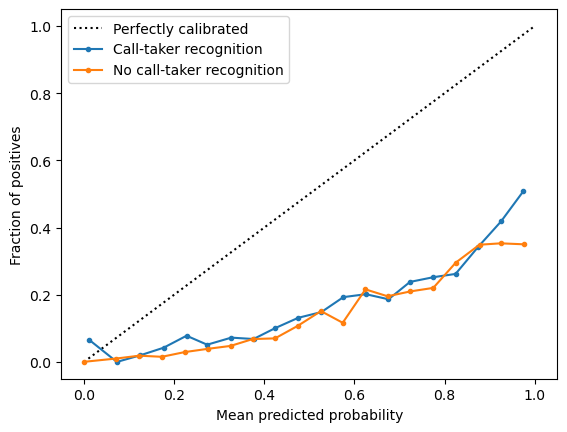

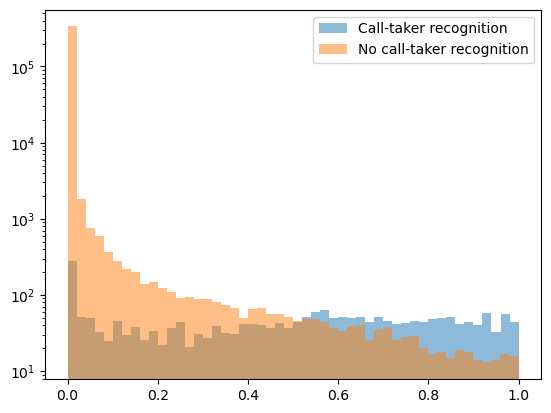

In [13]:
condition = median_ensemble_test["h"]

plot_calibration_curve(
    targets=[median_ensemble_test["y"][condition], median_ensemble_test["y"][~condition]],
    model_probs=[median_ensemble_test["ensemble_probs"][condition], median_ensemble_test["ensemble_probs"][~condition]],
    labels=["Call-taker recognition", "No call-taker recognition"],
    n_bins=20,
)
plot_histogram(
    arrays=[median_ensemble_test["ensemble_probs"][condition], median_ensemble_test["ensemble_probs"][~condition]],
    labels=["Call-taker recognition", "No call-taker recognition"],
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

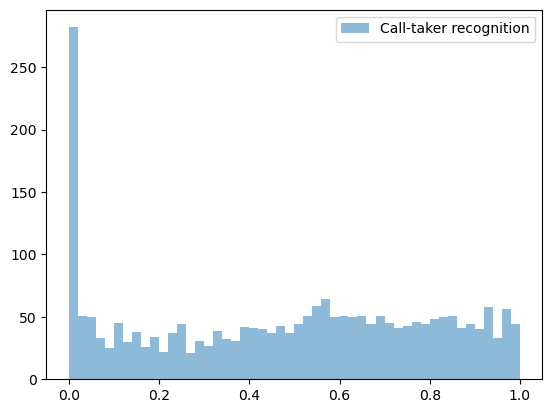

In [14]:
plot_histogram(
    arrays=[median_ensemble_test["ensemble_probs"][condition]],
    labels=["Call-taker recognition"],
    yscale="linear"
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

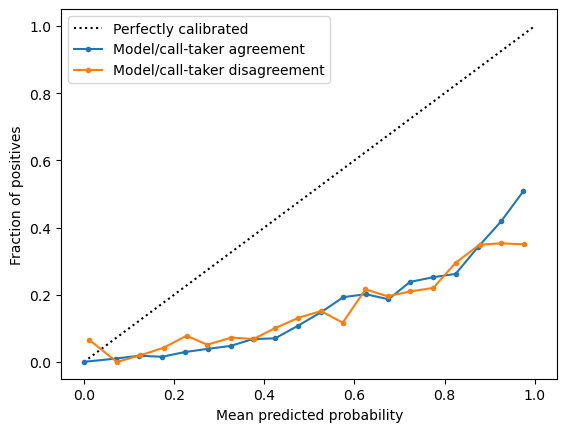

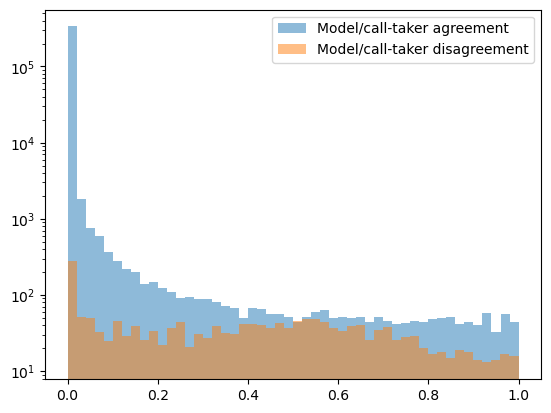

In [15]:
condition = median_ensemble_test["h"] == median_ensemble_test["ensemble_preds"]

plot_calibration_curve(
    targets=[median_ensemble_test["y"][condition], median_ensemble_test["y"][~condition]],
    model_probs=[median_ensemble_test["ensemble_probs"][condition], median_ensemble_test["ensemble_probs"][~condition]],
    labels=["Model/call-taker agreement", "Model/call-taker disagreement"],
    n_bins=20,
)
plot_histogram(
    arrays=[median_ensemble_test["ensemble_probs"][condition], median_ensemble_test["ensemble_probs"][~condition]],
    labels=["Model/call-taker agreement", "Model/call-taker disagreement"],
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

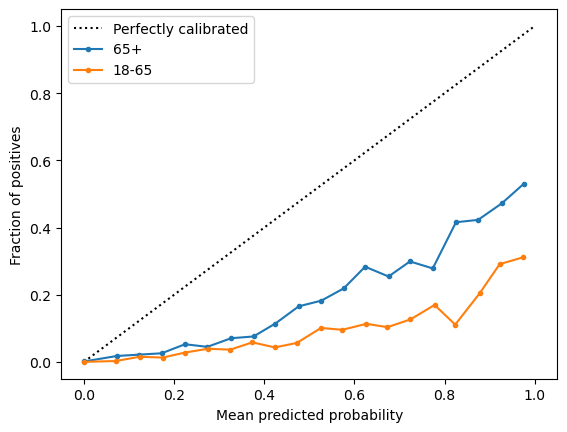

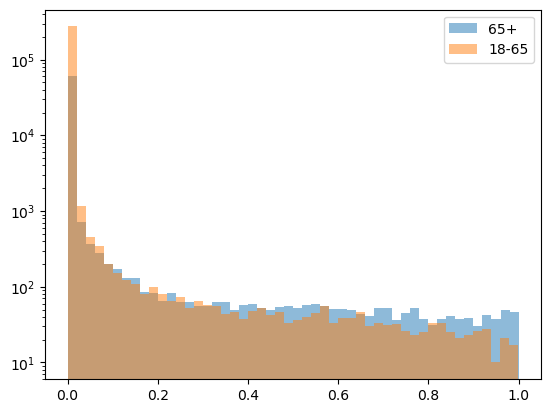

In [16]:
is_old = median_ensemble_test["age"] >= 65
plot_calibration_curve(
    targets=[median_ensemble_test["y"][is_old], median_ensemble_test["y"][~is_old]],
    model_probs=[median_ensemble_test["ensemble_probs"][is_old], median_ensemble_test["ensemble_probs"][~is_old]],
    labels=["65+", "18-65"],
    n_bins=20,
)
plot_histogram(
    arrays=[median_ensemble_test["ensemble_probs"][is_old], median_ensemble_test["ensemble_probs"][~is_old]],
    labels=["65+", "18-65"],
)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

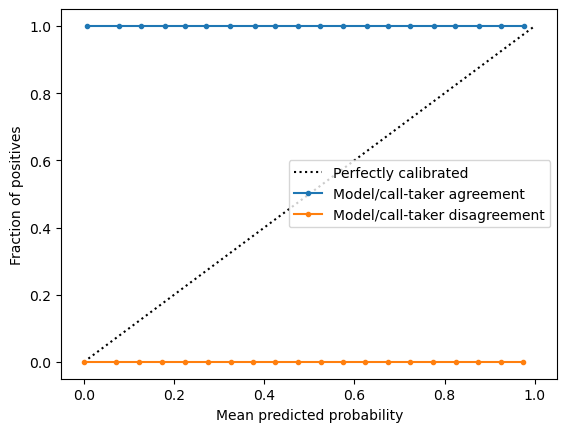

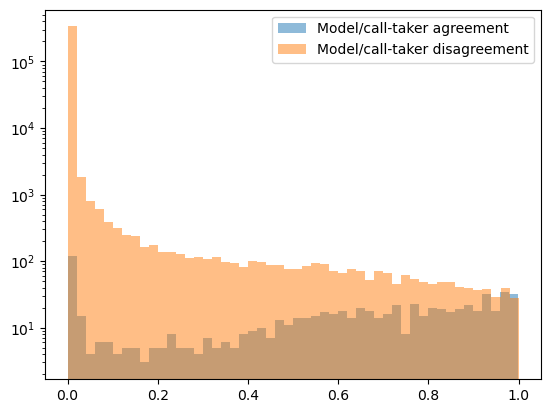

In [17]:
condition = median_ensemble_test["y"]

plot_calibration_curve(
    targets=[median_ensemble_test["y"][condition], median_ensemble_test["y"][~condition]],
    model_probs=[median_ensemble_test["ensemble_probs"][condition], median_ensemble_test["ensemble_probs"][~condition]],
    labels=["Model/call-taker agreement", "Model/call-taker disagreement"],
    n_bins=20,
)
plot_histogram(
    arrays=[median_ensemble_test["ensemble_probs"][condition], median_ensemble_test["ensemble_probs"][~condition]],
    labels=["Model/call-taker agreement", "Model/call-taker disagreement"],
)

# Calibration

## Platt scaling

In [18]:
logistic = LogisticRegression(penalty="none", fit_intercept=True)
logistic.fit(median_ensemble_val["ensemble_probs"].to_numpy()[:, np.newaxis], median_ensemble_val["y"].to_numpy())
ensemble_probs_logistic = logistic.predict_proba(median_ensemble_test["ensemble_probs"].to_numpy()[:, np.newaxis])[:, 1]
model_1_logistic = logistic.predict_proba(median_ensemble_test["probs 1"].to_numpy()[:, np.newaxis])[:, 1]

/opt/homebrew/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [19]:
logistic.coef_, logistic.intercept_, logistic.n_iter_

(array([[7.70084079]]), array([-7.02775596]), array([18], dtype=int32))

In [20]:
ensemble_probs_logistic.min(), ensemble_probs_logistic.max()

(0.0008861339036773544, 0.6617088319846024)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

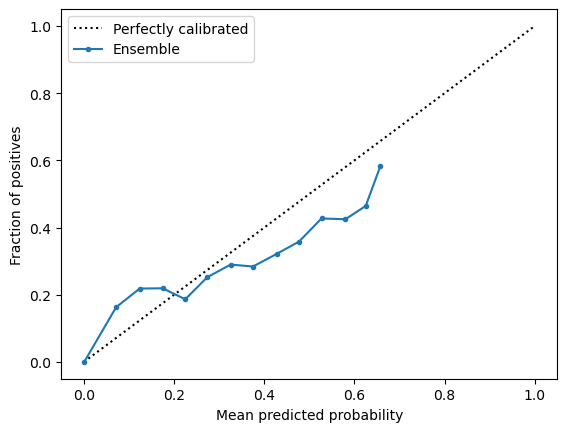

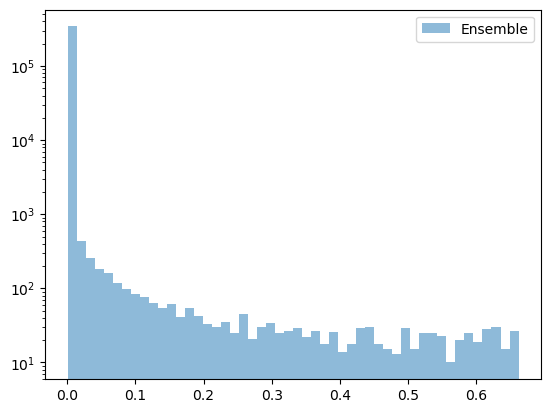

In [21]:
fig, ax = plot_calibration_curve(
    targets=median_ensemble_test["y"],
    model_probs=[ensemble_probs_logistic],
    labels=["Ensemble"],
    n_bins=20,
)
fig.savefig("calibration_curve_ensemble_logistic.pdf", bbox_inches="tight")
plot_histogram(arrays=[ensemble_probs_logistic], labels=["Ensemble"])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

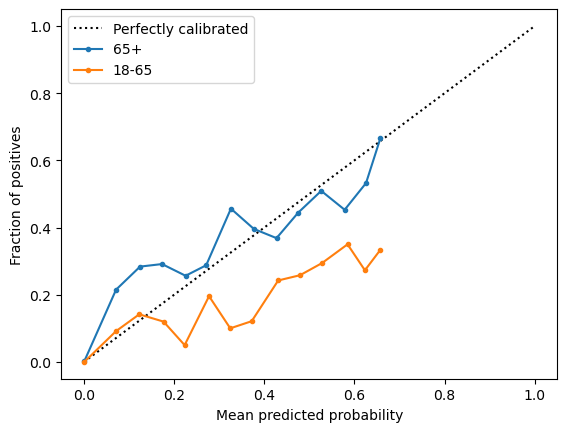

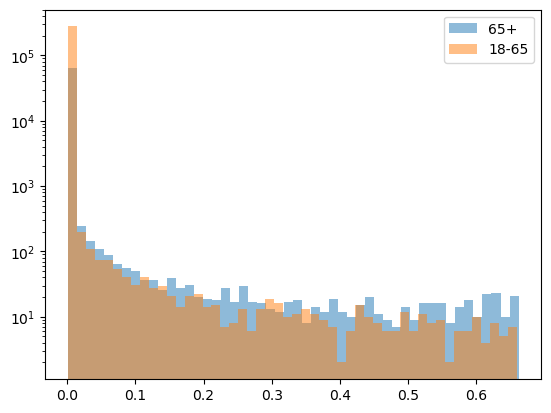

In [22]:
is_old = median_ensemble_test["age"] >= 65
plot_calibration_curve(
    targets=[median_ensemble_test["y"][is_old], median_ensemble_test["y"][~is_old]],
    model_probs=[ensemble_probs_logistic[is_old], ensemble_probs_logistic[~is_old]],
    labels=["65+", "18-65"],
    n_bins=20,
)
plot_histogram(
    arrays=[ensemble_probs_logistic[is_old], ensemble_probs_logistic[~is_old]],
    labels=["65+", "18-65"],
)

## Isotonic

In [23]:
isotonic = IsotonicRegression(y_min=0, y_max=1, increasing=True, out_of_bounds="clip")
isotonic.fit(median_ensemble_val["ensemble_probs"].to_numpy(), median_ensemble_val["y"].to_numpy())
ensemble_probs_isotonic = isotonic.transform(median_ensemble_test["ensemble_probs"].to_numpy())
model_1_isotonic = isotonic.transform(median_ensemble_test["probs 1"].to_numpy())

In [24]:
median_ensemble_val["ensemble_probs"]

0         8.563361e-06
1         5.884121e-08
2         2.681952e-12
3         1.951464e-12
4         5.211843e-07
              ...     
155820    2.844061e-05
155821    1.360998e-15
155822    2.097418e-08
155823    2.347738e-17
155824    1.010864e-12
Name: ensemble_probs, Length: 155825, dtype: float64

(<Figure size 640x480 with 1 Axes>, <Axes: >)

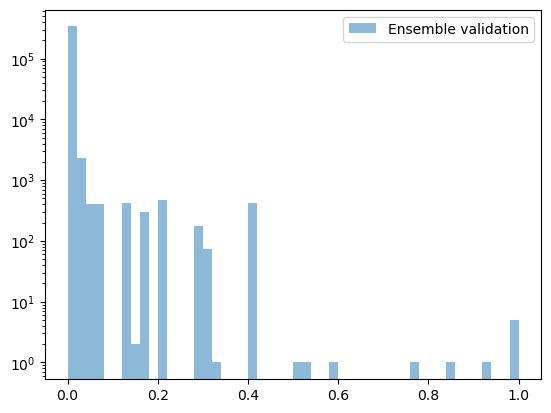

In [25]:
plot_histogram(arrays=[ensemble_probs_isotonic], labels=["Ensemble validation"])

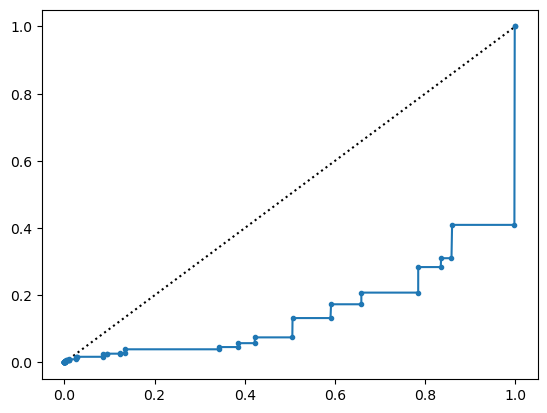

In [26]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.plot(isotonic.X_thresholds_, isotonic.y_thresholds_, "-", marker="o", markersize=3, label="Isotonic")

In [27]:
ensemble_probs_isotonic

array([0.0000000e+00, 5.8630394e-04, 0.0000000e+00, ..., 0.0000000e+00,
       5.8630394e-04, 9.7534015e-05])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

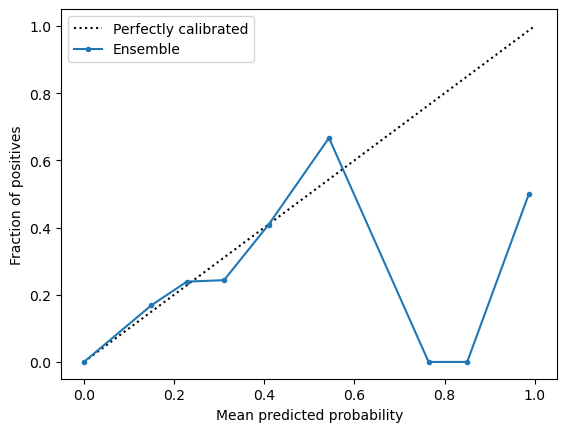

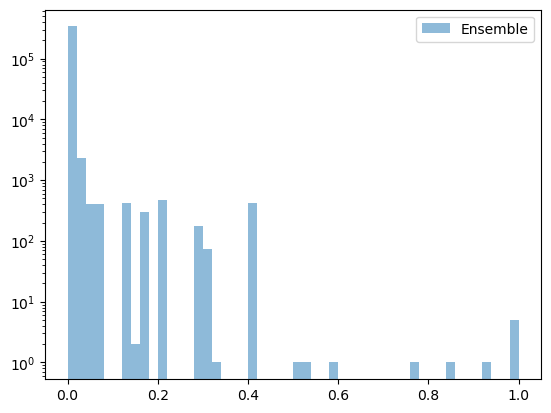

In [40]:
fig, ax = plot_calibration_curve(
    targets=median_ensemble_test["y"],
    model_probs=[ensemble_probs_isotonic],
    labels=["Ensemble", "Model 1"],
    n_bins=10,
    strategy="uniform",
    # n_bins=1000,
    # strategy="quantile",
)
fig.savefig("calibration_curve_ensemble_isotonic.pdf", bbox_inches="tight")
plot_histogram(arrays=[ensemble_probs_isotonic], labels=["Ensemble"])

In [29]:
median_ensemble_val

,db_id,logits 20,probs 20,logits 21,probs 21,logits 22,probs 22,logits 23,probs 23,logits 24,probs 24,ensemble_logits,ensemble_probs,y,h,gender,age,apotype,criteria_code,response_plan_type
0,6304efc6279c2ebd136e3b26,-14.503313,5.026793e-07,-11.940113,6.523369e-06,-10.768460,2.105271e-05,-7.410547,6.044740e-04,-14.156549,7.110308e-07,-14.231689,8.563361e-06,False,False,NaN,NaN,NaN,NaN,NaN
1,6304efc6279c2ebd136e3b38,-26.774380,2.355237e-12,-13.074266,2.098540e-06,-13.621290,1.214362e-06,-15.590428,1.694973e-07,-30.384405,6.371189e-14,-22.364847,5.884121e-08,False,False,NaN,NaN,NaN,NaN,NaN
2,6304efc6279c2ebd136e3b54,-39.800400,5.186877e-18,-22.933407,1.096852e-10,-23.701840,5.086534e-11,-26.916029,2.044170e-12,-35.158527,5.380784e-16,-32.177933,2.681952e-12,False,False,NaN,NaN,NaN,NaN,NaN
3,6304efc6279c2ebd136e3b74,-29.739079,1.214737e-13,-23.622833,5.504702e-11,-23.883448,4.241803e-11,-24.999554,1.389414e-11,-27.287508,1.409892e-12,-28.382377,1.951464e-12,False,False,NaN,NaN,NaN,NaN,NaN
4,6304efc6279c2ebd136e3b89,-22.026804,2.715693e-10,-19.258268,4.327532e-09,-12.721440,2.986396e-06,-10.284055,3.417251e-05,-31.495907,2.096532e-14,-21.633187,5.211843e-07,False,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155820,63ced18a144ac0aadbb86b44,-11.972542,6.315219e-06,-7.378309,6.242662e-04,-8.549907,1.935257e-04,-8.455875,2.126021e-04,-7.317329,6.634931e-04,-11.210685,2.844061e-05,False,False,NaN,NaN,NaN,NaN,NaN
155821,63ced18a144ac0aadbb86b7f,-44.987230,2.899312e-20,-29.896185,1.038130e-13,-35.539757,3.675190e-16,-41.947174,6.061411e-19,-46.462044,6.634234e-21,-42.242370,1.360998e-15,False,False,NaN,NaN,NaN,NaN,NaN
155822,63ced18a144ac0aadbb86b90,-24.552320,2.173015e-11,-15.884893,1.262637e-07,-14.117821,7.391082e-07,-15.980669,1.147317e-07,-35.087410,5.777387e-16,-23.600515,2.097418e-08,False,False,NaN,NaN,NaN,NaN,NaN
155823,63ced18a144ac0aadbb86bbf,-70.266914,3.044156e-31,-33.950910,1.800146e-15,-45.727960,1.382292e-20,-58.419630,4.252829e-26,-40.972180,1.606973e-18,-52.343410,2.347738e-17,False,False,NaN,NaN,NaN,NaN,NaN


## Temperature scaling

In [ ]:
raise Exception()

# Ensemble of ensembles

In [ ]:
all_ensembles_test

,db_id,y,h,ensemble 1 logits,ensemble 2 logits,ensemble 3 logits,ensemble 4 logits,ensemble 5 logits,ensemble 6 logits,ensemble 7 logits,...,ensemble 7 preds,ensemble 8 preds,ensemble 9 preds,ensemble 10 preds,ensemble 11 preds,gender,age,apotype,criteria_code,response_plan_type
0,63d13ca5c800e251f5a62955,False,False,-79.232867,-85.658688,-83.568260,-56.540886,-74.293595,-82.016231,-73.156988,...,False,False,False,False,False,M,45,NaN,SS.80.02,NaN
1,63d13ca5c800e251f5a6295d,False,False,-13.491096,-12.557148,-13.277465,-8.835392,-10.745789,-12.947465,-11.185823,...,False,False,False,False,False,M,71,NaN,SS.05.03,NaN
2,63d13ca5c800e251f5a62973,False,False,-44.867976,-47.767789,-48.386297,-32.319910,-38.124604,-48.528648,-39.074920,...,False,False,False,False,False,M,62,NaN,SS.23.02,NaN
3,63d13ca5c800e251f5a62978,False,False,-9.586739,-10.481780,-9.711383,-8.477529,-8.078248,-9.538295,-9.214727,...,False,False,False,False,False,K,19,NaN,SS.80.02,NaN
4,63d13ca5c800e251f5a6297f,False,False,-32.566561,-36.753484,-35.039346,-25.726163,-28.768769,-33.227218,-33.021645,...,False,False,False,False,False,K,54,NaN,SS.80.02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344025,63d17383c800e251f5c2febb,False,False,-60.728896,-69.466228,-64.434332,-48.618299,-54.940430,-65.762336,-60.504548,...,False,False,False,False,False,K,38,NaN,SS.22.04.04.01.03,NaN
344026,63d17383c800e251f5c2febc,False,False,-30.294403,-31.344756,-34.129899,-28.108232,-24.530117,-33.424636,-27.025287,...,False,False,False,False,False,M,60,NaN,SS.05.01.08,NaN
344027,63d17383c800e251f5c2fedc,False,False,-103.454726,-111.353909,-106.430621,-68.888460,-88.872203,-113.598883,-90.036581,...,False,False,False,False,False,M,51,NaN,SS.01.04.03.02,NaN
344028,63d17383c800e251f5c2fee9,False,False,-14.547315,-15.026930,-14.254186,-12.680787,-11.723701,-18.872362,-15.431524,...,False,False,False,False,False,K,68,NaN,SS.27.05,NaN


In [ ]:
all_ensembles_val

,db_id,y,h,ensemble 1 logits,ensemble 2 logits,ensemble 3 logits,ensemble 4 logits,ensemble 5 logits,ensemble 6 logits,ensemble 7 logits,...,ensemble 7 preds,ensemble 8 preds,ensemble 9 preds,ensemble 10 preds,ensemble 11 preds,gender,age,apotype,criteria_code,response_plan_type
0,6304efc6279c2ebd136e3b26,False,False,-16.546333,-20.149596,-13.491189,-11.678281,-14.231689,-15.842842,-15.852648,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
1,6304efc6279c2ebd136e3b38,False,False,-24.864744,-25.708100,-29.483372,-21.802551,-22.364847,-25.881039,-26.254696,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2,6304efc6279c2ebd136e3b54,False,False,-35.779230,-40.325944,-39.135565,-28.314378,-32.177933,-39.801616,-35.974174,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
3,6304efc6279c2ebd136e3b74,False,False,-32.599887,-33.207130,-33.053438,-24.115371,-28.382377,-34.920975,-28.086560,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
4,6304efc6279c2ebd136e3b89,False,False,-30.774794,-27.590860,-27.373393,-17.506266,-21.633187,-32.290898,-26.522554,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155820,63ced18a144ac0aadbb86b44,False,False,-13.084375,-13.775417,-12.971013,-10.400472,-11.210685,-13.838170,-11.652766,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
155821,63ced18a144ac0aadbb86b7f,False,False,-48.547955,-52.906606,-53.991951,-34.041531,-42.242370,-52.241940,-46.611636,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
155822,63ced18a144ac0aadbb86b90,False,False,-23.616774,-31.472163,-29.833035,-21.084576,-23.600515,-27.380585,-24.059741,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
155823,63ced18a144ac0aadbb86bbf,False,False,-52.793703,-56.916020,-64.838366,-57.923717,-52.343410,-61.479739,-55.516727,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_ensembles_test_probs = [all_ensembles_test[f"ensemble {i} probs"] for i in range(1, 12)]
labels = [f"Ensemble {i}" for i in range(1, 12)]

plot_calibration_curve(
    targets=median_ensemble_test["y"],
    model_probs=all_ensembles_test_probs,
    labels=labels,
    n_bins=20,
)

: 

In [ ]:
all_ensembles_test_probs = np.stack([all_ensembles_test[f"ensemble {i} probs"] for i in range(1, 12)])
all_ensembles_test_preds = np.stack([all_ensembles_test[f"ensemble {i} preds"] for i in range(1, 12)])
all_ensembles_val_probs = np.stack([all_ensembles_val[f"ensemble {i} probs"] for i in range(1, 12)])
all_ensembles_val_preds = np.stack([all_ensembles_val[f"ensemble {i} preds"] for i in range(1, 12)])
all_ensembles_test_preds.shape

(11, 344030)

In [ ]:
med_ensemble_test = median_ensemble_test["ensemble_probs"]
# majority_vote_test = np.mean(all_ensembles_test_preds, axis=0) > 0.5
super_ensemble_probs_test = scipy.stats.hmean(all_ensembles_test_probs, axis=0)
mean_ensemble_probs_test = np.mean(all_ensembles_test_probs, axis=0)

med_ensemble_val = median_ensemble_val["ensemble_probs"]
# majority_vote_val = np.mean(all_ensembles_test_preds, axis=0) > 0.5
super_ensemble_probs_val = scipy.stats.hmean(all_ensembles_val_probs, axis=0)
mean_ensemble_probs_val = np.mean(all_ensembles_val_probs, axis=0)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

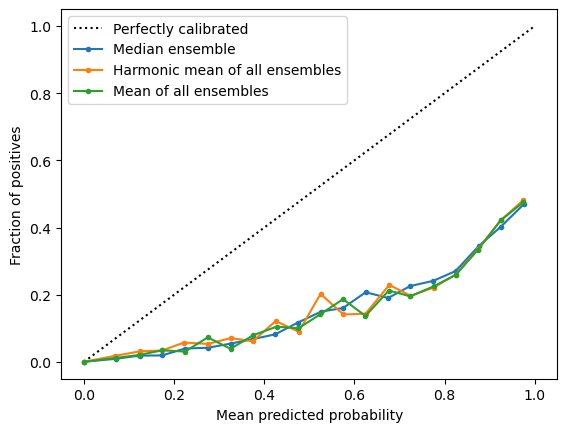

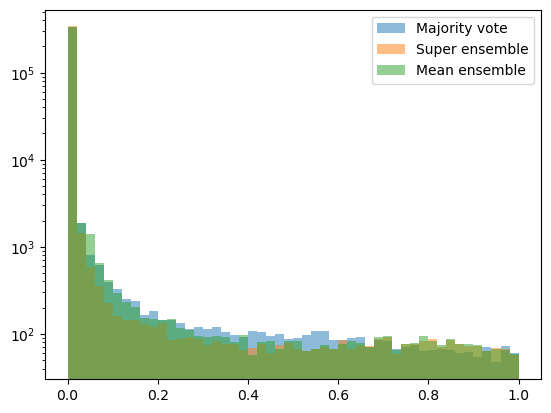

In [ ]:
plot_calibration_curve(
    targets=median_ensemble_test["y"],
    model_probs=[med_ensemble_test, super_ensemble_probs_test, mean_ensemble_probs_test],
    labels=["Median ensemble", "Harmonic mean of all ensembles", "Mean of all ensembles"],
    n_bins=20,
)
plot_histogram(arrays=[med_ensemble_test, super_ensemble_probs_test, mean_ensemble_probs_test], labels=["Majority vote", "Super ensemble", "Mean ensemble"])

## Platt scaling

In [ ]:
logistic = LogisticRegression(penalty="none", fit_intercept=True)
logistic.fit(super_ensemble_probs_val[:, np.newaxis], median_ensemble_val["y"].to_numpy())
ensemble_probs_logistic = logistic.predict_proba(super_ensemble_probs_test[:, np.newaxis])[:, 1]

/opt/homebrew/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [ ]:
logistic.coef_, logistic.intercept_, logistic.n_iter_

(array([[7.53993341]]), array([-6.99494849]), array([18], dtype=int32))

In [ ]:
ensemble_probs_logistic.min(), ensemble_probs_logistic.max()

(0.0009156607955655689, 0.6324382251209166)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

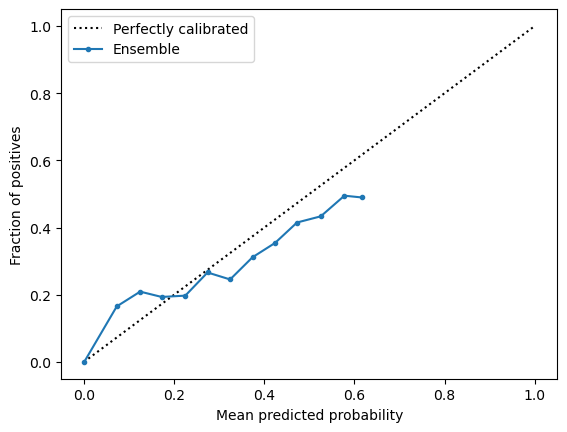

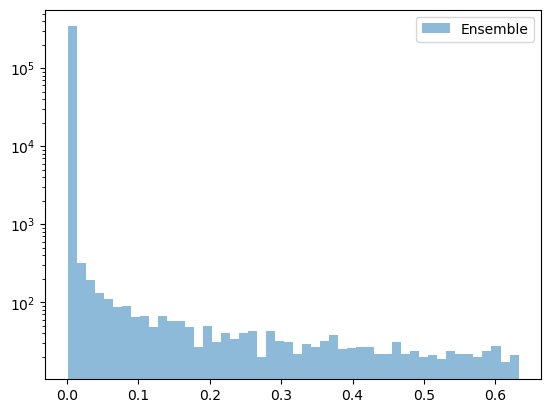

In [ ]:
plot_calibration_curve(
    targets=median_ensemble_test["y"],
    model_probs=[ensemble_probs_logistic],
    labels=["Ensemble"],
    n_bins=20,
)
plot_histogram(arrays=[ensemble_probs_logistic], labels=["Ensemble"])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

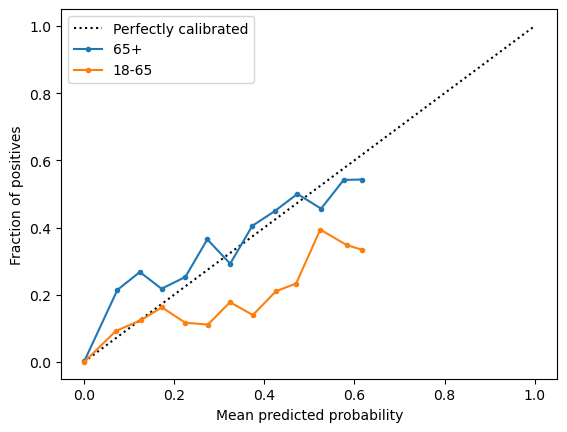

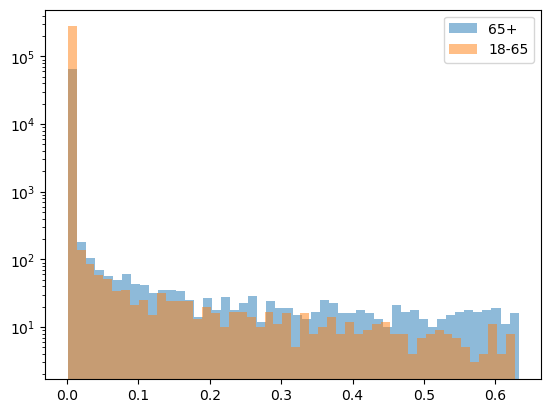

In [ ]:
is_old = median_ensemble_test["age"] >= 65
plot_calibration_curve(
    targets=[median_ensemble_test["y"][is_old], median_ensemble_test["y"][~is_old]],
    model_probs=[ensemble_probs_logistic[is_old], ensemble_probs_logistic[~is_old]],
    labels=["65+", "18-65"],
    n_bins=20,
)
plot_histogram(
    arrays=[ensemble_probs_logistic[is_old], ensemble_probs_logistic[~is_old]],
    labels=["65+", "18-65"],
)

## Isotonic

In [ ]:
isotonic = IsotonicRegression(y_min=0, y_max=1, increasing=True, out_of_bounds="clip")
isotonic.fit(super_ensemble_probs_val, median_ensemble_val["y"])
ensemble_probs_isotonic = isotonic.transform(super_ensemble_probs_test)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

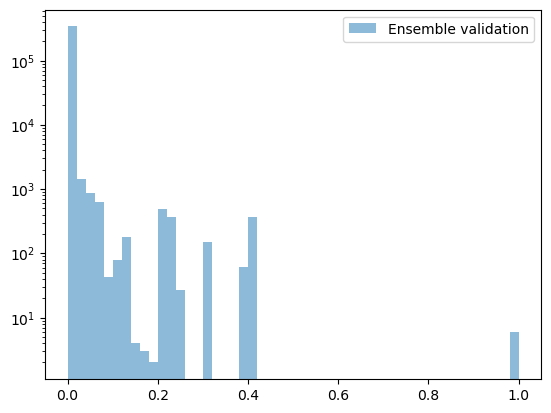

In [ ]:
plot_histogram(arrays=[ensemble_probs_isotonic], labels=["Ensemble validation"])

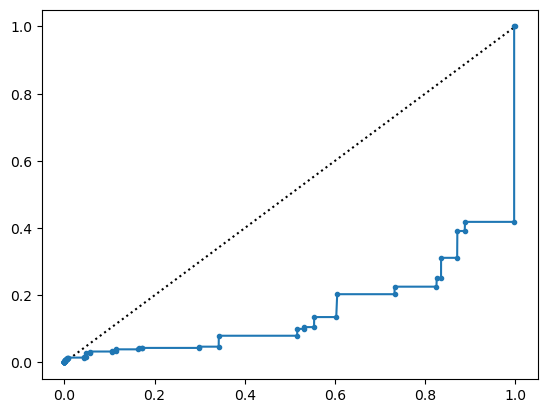

In [ ]:
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.plot(isotonic.X_thresholds_, isotonic.y_thresholds_, "-", marker="o", markersize=3, label="Isotonic")

(<Figure size 640x480 with 1 Axes>, <Axes: >)

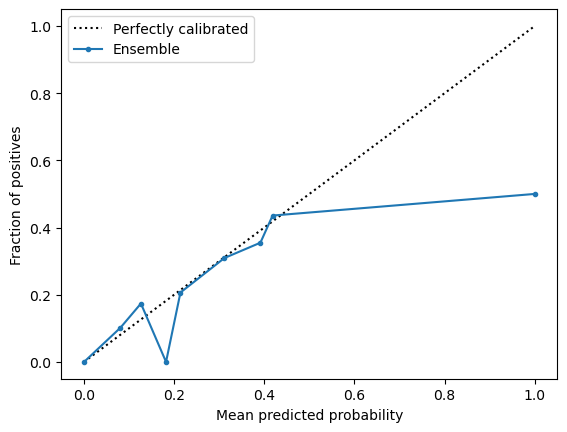

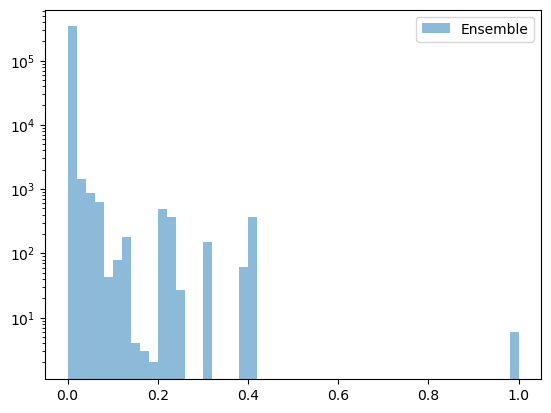

In [ ]:
plot_calibration_curve(
    targets=median_ensemble_test["y"],
    model_probs=[ensemble_probs_isotonic],
    labels=["Ensemble"],
    n_bins=20,
)
plot_histogram(arrays=[ensemble_probs_isotonic], labels=["Ensemble"])